In [1]:
# File processing
import os

# Data processing
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Machine Learning
import random
import torch
import torch.nn.functional as F
from torch import linalg as LAtorch
from numpy import linalg as LAnumpy

# Plotting
import matplotlib.pyplot as plt

# Curve fitting
import pylab as plb
from scipy.optimize import curve_fit

# Set device type
device = torch.device('cpu')

# Constants

In [2]:
# Models constants
SEED = 0
BATCH_SIZE = 1
EMBEDDING_SIZE = 3 # Euclidean 3D space

# Trussart test set constants
NB_BINS = 202
TRUSSART_HIC_PATH = '../data/trussart/hic_matrices/150_TADlike_alpha_150_set0.mat'
TRUSSART_STRUCTURES_PATH = '../data/trussart/structure_matrices/'
NB_TRUSSART_STRUCTURES = 100

# Seeds

In [3]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Trussart dataset

## Hic matrice

In [4]:
trussart_hic = np.loadtxt(TRUSSART_HIC_PATH, dtype='f', delimiter='\t')
scaler = MinMaxScaler()
trussart_hic = scaler.fit_transform(trussart_hic)

## Structure matrices

In [5]:
trussart_structures = []

file_list = os.listdir(TRUSSART_STRUCTURES_PATH)
file_list = filter(lambda f: f.endswith('.xyz'), file_list)

for file_name in file_list:
    current_trussart_structure = np.loadtxt(TRUSSART_STRUCTURES_PATH + file_name, dtype='f', delimiter='\t')
    current_trussart_structure = current_trussart_structure[:,1:]
    trussart_structures.append(current_trussart_structure)

# Structure analysis functions

### Torch

In [6]:
def centralize_torch(z):
    return z - torch.repeat_interleave(torch.reshape(torch.mean(z, axis=1), (-1,1,EMBEDDING_SIZE)), NB_BINS, dim=1)

In [7]:
def normalize_torch(z):
    
    norms = LAtorch.norm(z, 2, dim=2)
    max_norms, _ = torch.max(norms, axis=1)
    max_norms = torch.reshape(max_norms, (BATCH_SIZE,1,1))
    max_norms = torch.repeat_interleave(max_norms, NB_BINS, dim=1)
    max_norms = torch.repeat_interleave(max_norms, EMBEDDING_SIZE, dim=2)
    max_norms[max_norms == 0] = 1
    
    return z / max_norms

In [8]:
def centralize_and_normalize_torch(z):
    
    # Translate
    z = centralize_torch(z)
    
    # Scale
    z = normalize_torch(z)
    
    return z

### Numpy

In [9]:
def centralize_numpy(z):
    return z - np.mean(z, axis=0)

In [10]:
def normalize_numpy(z):
    
    norm = LAnumpy.norm(z, 2, axis=1)
    max_norm = np.max(norm, axis=0)
    if max_norm == 0:
        max_norm = 1
    
    return z / max_norm

In [11]:
def centralize_and_normalize_numpy(z):
    
    # Translate
    z = centralize_numpy(z)
    
    # Scale
    z = normalize_numpy(z)
    
    return z

In [12]:
def kabsch_superimposition_numpy(pred_structure, true_structure):
    
    # Centralize and normalize to unit ball
    pred_structure_unit_ball = centralize_and_normalize_numpy(pred_structure)
    true_structure_unit_ball = centralize_and_normalize_numpy(true_structure)
    
    # Rotation (solution for the constrained orthogonal Procrustes problem, subject to det(R) = 1)
    m = np.matmul(np.transpose(true_structure_unit_ball), pred_structure_unit_ball)
    u, s, vh = np.linalg.svd(m)
    
    d = np.sign(np.linalg.det(np.matmul(u, vh)))
    a = np.eye(EMBEDDING_SIZE)
    a[-1,-1] = d
    
    r = np.matmul(np.matmul(u, a), vh)
    
    pred_structure_unit_ball = np.transpose(np.matmul(r, np.transpose(pred_structure_unit_ball)))
    
    return pred_structure_unit_ball, true_structure_unit_ball

In [13]:
def kabsch_distance_numpy(pred_structure, true_structure):
    
    pred_structure_unit_ball, true_structure_unit_ball = kabsch_superimposition_numpy(pred_structure, true_structure)
    
    # Structure comparison
    d = np.mean(np.sum(np.square(pred_structure_unit_ball - true_structure_unit_ball), axis=1))
    
    return d

# Preprocess dataset

In [14]:
centralized_and_normalized_structures = []

for structure in trussart_structures:
    structure = centralize_and_normalize_numpy(structure)
    centralized_and_normalized_structures.append(structure)
    
centralized_and_normalized_structures = np.asarray(centralized_and_normalized_structures)

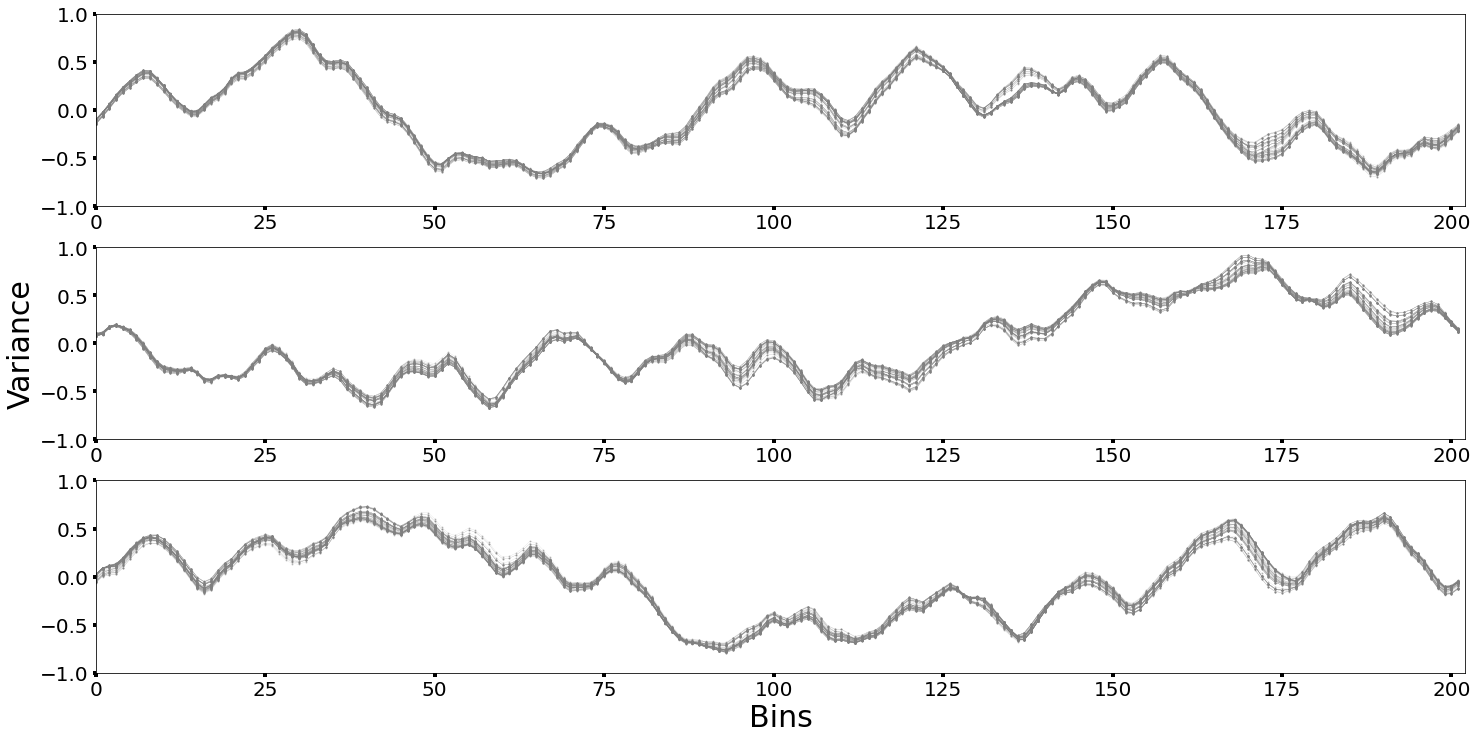

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10))
fig.tight_layout(pad=2.0)
axis_names = ['X','Y','Z']

# Plot prediction
for j in range(EMBEDDING_SIZE):

    axs[j].set_xlim(0, NB_BINS)
    axs[j].set_ylim(-1, 1)
    axs[j].tick_params(axis='both', which='major', labelsize=20, width=4)

    if j == 2:
        axs[j].set_xlabel('Bins', fontsize=30)
    if j == 1:
        axs[j].set_ylabel('Variance', fontsize=30)

    for k in range(NB_TRUSSART_STRUCTURES):
        axs[j].plot(range(NB_BINS), centralized_and_normalized_structures[k,:,j], color='gray', 
              marker='o', linestyle='solid', linewidth=0.2, markersize=1, alpha=0.4)

#             plt.savefig('sample_per_axis_structure_variance.png')

plt.show()

In [16]:
# True variation between the Trussart structures
per_axis_variance = np.var(centralized_and_normalized_structures, axis=0)
per_axis_variance.shape

(202, 3)

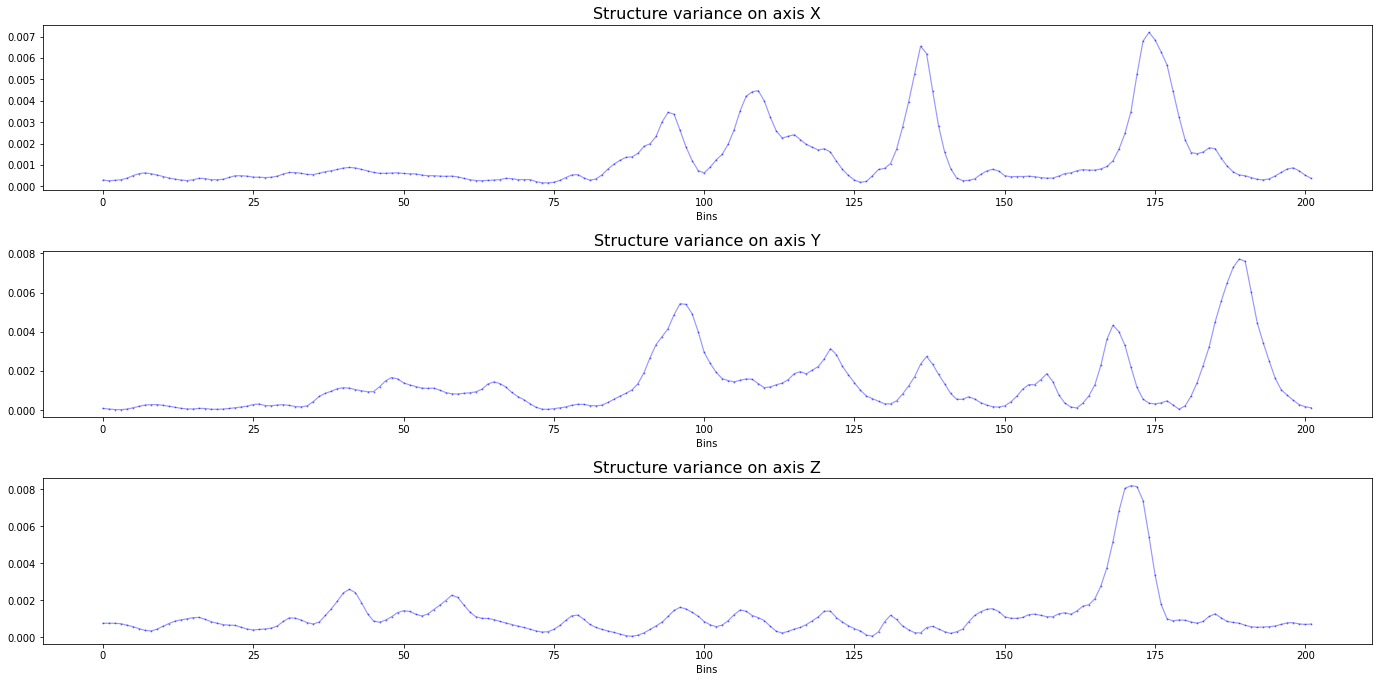

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(20,10))
fig.tight_layout(pad=4.0)
axis_names = ['X','Y','Z']

for i in range(EMBEDDING_SIZE):

    # Trussart
    axes[i].plot(range(NB_BINS), per_axis_variance[:,i], color='blue', 
                  marker='o', linestyle='solid', linewidth=1.2, markersize=1, alpha=0.4)

    axes[i].set_title('Structure variance on axis ' + axis_names[i], fontsize=16)
    axes[i].set_xlabel('Bins', fontsize=10)

plt.show()

# Gaussian Fit

In [18]:
def gaus(x,a,x0,sigma):
    return np.asarray(a* np.exp(-(x-x0)**2/(2*sigma**2)))

In [19]:
def gaussian_fit(x, y):

    n = len(x)                          #the number of data
    mean = sum(x*y)/n                   #note this correction
    sigma = sum(y*(x-mean)**2)/n        #note this correction

    popt,pcov = curve_fit(gaus,x,y, maxfev=100000)

    plt.plot(x,y,'b+:',label='data')
    plt.plot(x,gaus(x,*popt),'ro:',label='fit')
    plt.legend()
    plt.show()

    return popt

## Trussart X axis

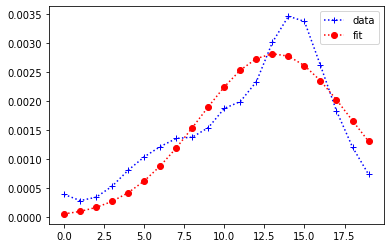

array([ 2.81651931e-03,  9.31674959e+01, -4.70503414e+00])

In [20]:
x = np.asarray(range(20))
y = per_axis_variance[80:100,0]

gaussian_1_params = gaussian_fit(x, y)
gaussian_1_params[1] += 80
gaussian_1_params

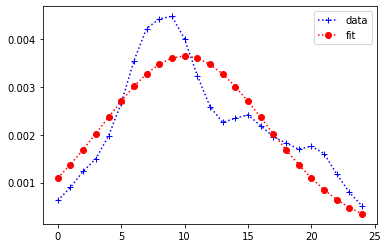

array([3.64695415e-03, 1.09992897e+02, 6.44205303e+00])

In [21]:
x = np.asarray(range(25))
y = per_axis_variance[100:125,0]

gaussian_2_params = gaussian_fit(x, y)
gaussian_2_params[1] += 100
gaussian_2_params

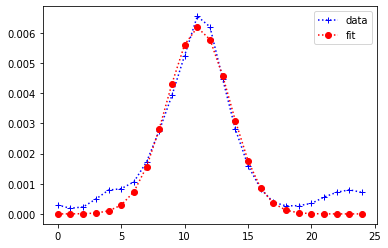

array([6.19132978e-03, 1.36092707e+02, 2.46607926e+00])

In [22]:
x = np.asarray(range(25))
y = per_axis_variance[125:150,0]

gaussian_3_params = gaussian_fit(x, y)
gaussian_3_params[1] += 125
gaussian_3_params

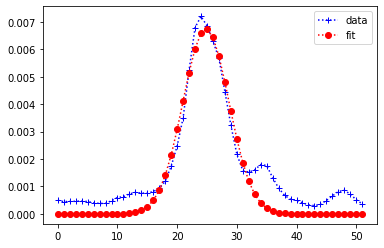

array([6.73906199e-03, 1.74826794e+02, 3.85512780e+00])

In [23]:
x = np.asarray(range(52))
y = per_axis_variance[150:,0]

gaussian_4_params = gaussian_fit(x, y)
gaussian_4_params[1] += 150
gaussian_4_params

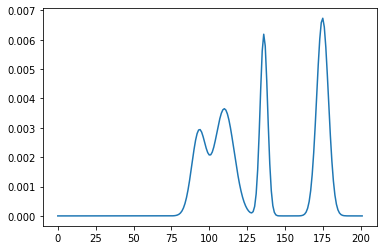

In [24]:
x = np.asarray(range(NB_BINS))

gauss_1 = gaus(x, gaussian_1_params[0], gaussian_1_params[1], gaussian_1_params[2])
gauss_2 = gaus(x, gaussian_2_params[0], gaussian_2_params[1], gaussian_2_params[2])
gauss_3 = gaus(x, gaussian_3_params[0], gaussian_3_params[1], gaussian_3_params[2])
gauss_4 = gaus(x, gaussian_4_params[0], gaussian_4_params[1], gaussian_4_params[2])

variance_modeling_axis_x = gauss_1 + gauss_2 + gauss_3 + gauss_4

plt.plot(x, variance_modeling_axis_x)

plt.show()

## Trussart Y axis

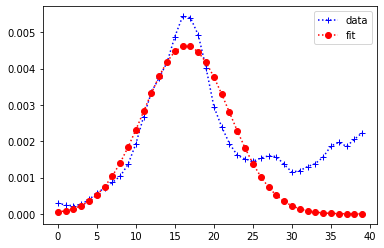

array([4.63306411e-03, 9.64725986e+01, 5.49112057e+00])

In [25]:
x = np.asarray(range(40))
y = per_axis_variance[80:120,1]

gaussian_1_params = gaussian_fit(x, y)
gaussian_1_params[1] += 80
gaussian_1_params

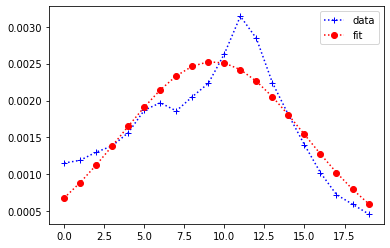

array([2.52782759e-03, 1.19291159e+02, 5.73484487e+00])

In [26]:
x = np.asarray(range(20))
y = per_axis_variance[110:130,1]

gaussian_2_params = gaussian_fit(x, y)
gaussian_2_params[1] += 110
gaussian_2_params

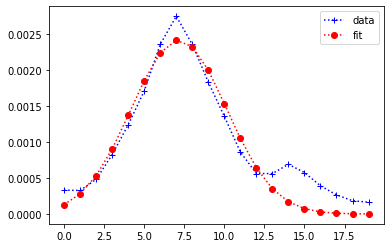

array([2.41472743e-03, 1.37163429e+02, 2.96816307e+00])

In [27]:
x = np.asarray(range(20))
y = per_axis_variance[130:150,1]

gaussian_3_params = gaussian_fit(x, y)
gaussian_3_params[1] += 130
gaussian_3_params

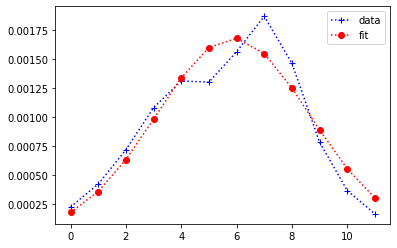

array([1.68122566e-03, 1.55872363e+02, 2.77125228e+00])

In [28]:
x = np.asarray(range(12))
y = per_axis_variance[150:162,1]

gaussian_4_params = gaussian_fit(x, y)
gaussian_4_params[1] += 150
gaussian_4_params

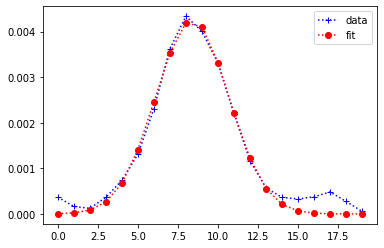

array([4.25187876e-03, 1.68393902e+02, 2.28387346e+00])

In [29]:
x = np.asarray(range(20))
y = per_axis_variance[160:180,1]

gaussian_5_params = gaussian_fit(x, y)
gaussian_5_params[1] += 160
gaussian_5_params

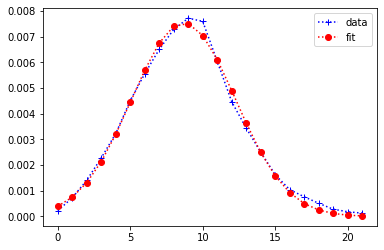

array([7.53788597e-03, 1.88680037e+02, 3.57517827e+00])

In [30]:
x = np.asarray(range(22))
y = per_axis_variance[180:,1]

gaussian_6_params = gaussian_fit(x, y)
gaussian_6_params[1] += 180
gaussian_6_params

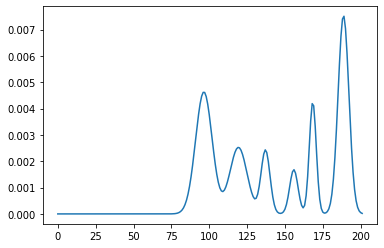

In [31]:
x = np.asarray(range(NB_BINS))

gauss_1 = gaus(x, gaussian_1_params[0], gaussian_1_params[1], gaussian_1_params[2])
gauss_2 = gaus(x, gaussian_2_params[0], gaussian_2_params[1], gaussian_2_params[2])
gauss_3 = gaus(x, gaussian_3_params[0], gaussian_3_params[1], gaussian_3_params[2])
gauss_4 = gaus(x, gaussian_4_params[0], gaussian_4_params[1], gaussian_4_params[2])
gauss_5 = gaus(x, gaussian_5_params[0], gaussian_5_params[1], gaussian_5_params[2])
gauss_6 = gaus(x, gaussian_6_params[0], gaussian_6_params[1], gaussian_6_params[2])

variance_modeling_axis_y = gauss_1 + gauss_2 + gauss_3 + gauss_4 + gauss_5 + gauss_6

plt.plot(x, variance_modeling_axis_y)

plt.show()

## Trussart Z axis

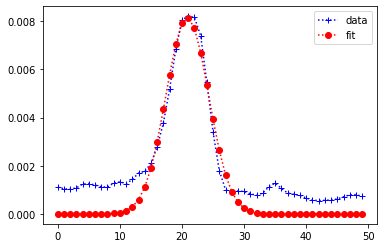

array([8.15516583e-03, 1.70851094e+02, 3.42844501e+00])

In [32]:
x = np.asarray(range(50))
y = per_axis_variance[150:200,2]

gaussian_1_params = gaussian_fit(x, y)
gaussian_1_params[1] += 150
gaussian_1_params

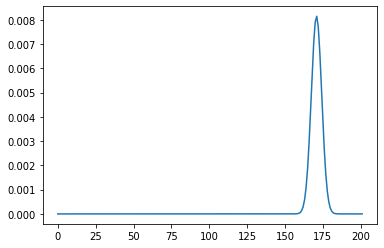

In [33]:
x = np.asarray(range(NB_BINS))

gauss_1 = gaus(x, gaussian_1_params[0], gaussian_1_params[1], gaussian_1_params[2])

variance_modeling_axis_z = gauss_1

plt.plot(x, variance_modeling_axis_z)

plt.show()

# Final variance modeling

In [34]:
variance_modeling = \
    np.vstack((np.vstack((variance_modeling_axis_x, variance_modeling_axis_y)), variance_modeling_axis_z))

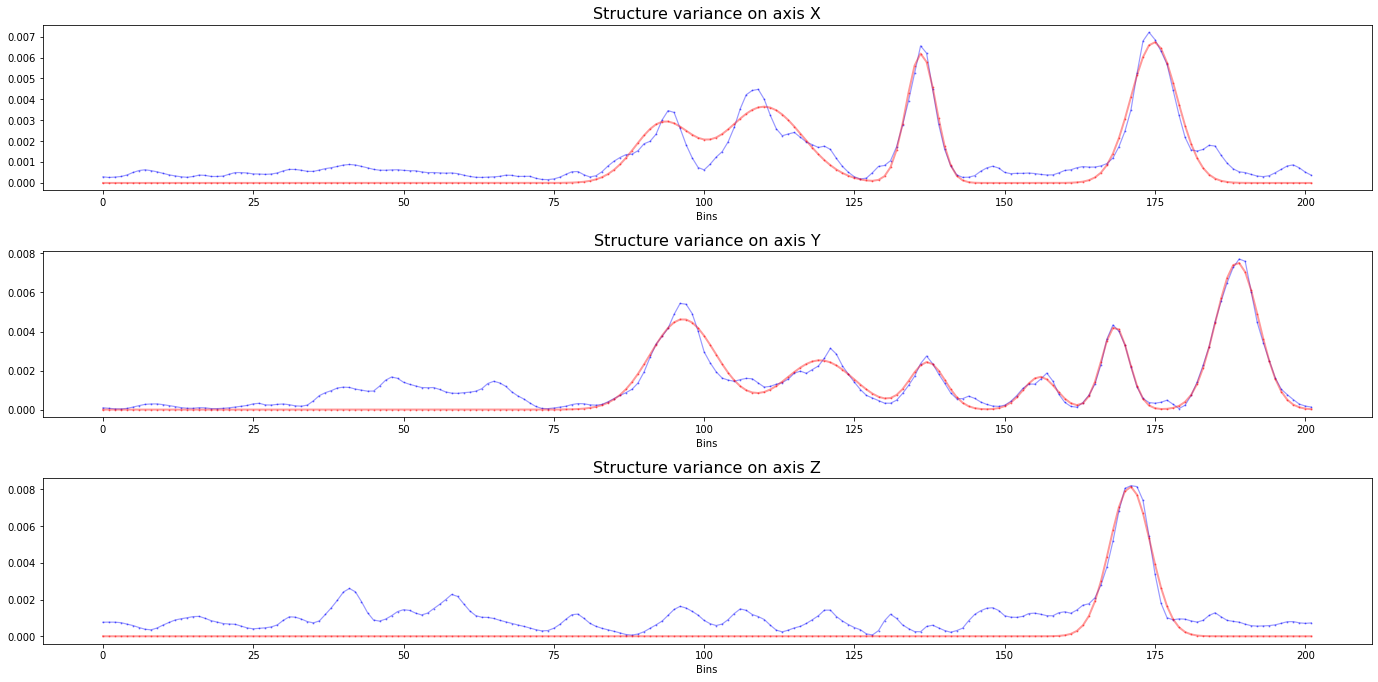

In [35]:
fig, axes = plt.subplots(3, 1, figsize=(20,10))
fig.tight_layout(pad=4.0)
axis_names = ['X','Y','Z']

for i in range(EMBEDDING_SIZE):

    # Trussart
    axes[i].plot(range(NB_BINS), per_axis_variance[:,i], color='blue', 
                  marker='o', linestyle='solid', linewidth=1.2, markersize=1, alpha=0.4)
    axes[i].plot(range(NB_BINS), variance_modeling[i,:], color='red', 
                  marker='o', linestyle='solid', linewidth=2, markersize=1, alpha=0.4)

    axes[i].set_title('Structure variance on axis ' + axis_names[i], fontsize=16)
    axes[i].set_xlabel('Bins', fontsize=10)

plt.show()